In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
from matplotlib.lines import Line2D

In [2]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [3]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [4]:
#setting file path and ensemble codes
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
 
coupled_july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767'] 
coupled_jan = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]

In [5]:
### JULY ### 
saod_july = iris.cube.CubeList()
for job_id in coupled_july:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm. [6:120] = from point of eruption

    saod_july.append(total_SAOD_550)

In [6]:
## JAN ### 
saod_jan = iris.cube.CubeList()
for job_id in coupled_jan:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3)) #550nm

    saod_jan.append(total_SAOD_550)

In [7]:
#merging list of cubes into single large cube
one_big_july = merge_cubes(saod_july)
one_big_jan = merge_cubes(saod_jan)

In [8]:
## JULY ##
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90)# Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0)# Southern Hemisphere

#Calculating SAOD ratio
july_ratio = iris.cube.CubeList()

for i in range(0,9):
    nh_saod = saod_july[i].extract(NH_constraint)
    sh_saod = saod_july[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg) / (nh_avg+sh_avg)
               
    july_ratio.append(ratio)

In [9]:
## JAN ## 
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90)# Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0)# Southern Hemisphere

#Calculating SAOD ratio
jan_ratio = iris.cube.CubeList()

for i in range(0,9):
    nh_saod = saod_jan[i].extract(NH_constraint)
    sh_saod = saod_jan[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg) / (nh_avg+sh_avg)
               
    jan_ratio.append(ratio)

In [10]:
#merging ratio cubes
big_july_ratios = merge_cubes(july_ratio)
big_jan_ratios = merge_cubes(jan_ratio)

In [11]:
#calculating mean ratio by grouping
mean_july = big_july_ratios.collapsed('realization',iris.analysis.MEAN)
mean_jan = big_jan_ratios.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [12]:
#defining two times 
time_1 = range(0,114)#to align with july
time_2 = range(0,120)#to align with jan

In [13]:
#zero line
zero = []
for n in range(0,120):
    n = 0
    zero.append(n)

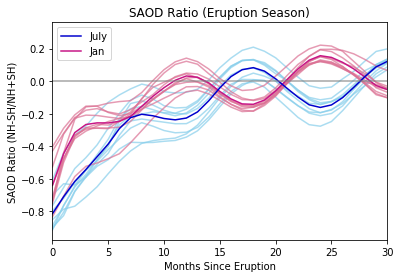

In [14]:
for cube in big_july_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='skyblue', alpha = 0.7)

for cube in big_jan_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_2,cube.data,color='palevioletred', alpha = 0.7)

#plotting means
plt.plot(time_2,mean_jan.data,color='mediumvioletred')
plt.plot(time_1, mean_july.data,color='mediumblue')

plt.plot(time_2,zero,color='grey', alpha = 0.7)
    
plt.xlim(time_1[0],time_1[30]) # plot only 5 years

plt.title('SAOD Ratio (Eruption Season)')
plt.xlabel('Months Since Eruption')
plt.ylabel('SAOD Ratio (NH-SH/NH+SH)')
july_line = Line2D([0], [0], label='July', color='mediumblue')
jan_line = Line2D([0], [0], label='Jan', color='mediumvioletred')
plt.legend(handles=[july_line, jan_line])

plt.savefig('SAOD_Ratio.pdf')
